# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Lab 3: Linear Regression and kNN

**Harvard University**<br/>
**Fall 2025**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader<br/>
**Preceptor**: Chris Gumb<br/>
<hr style='height:2px'>

### Contents:
* Bikeshare EDA - (10 min)
* Single variable linear regression - (10 min)
* Exercise 1: Linear model assumptions - (5 mins)
* Multivariable linear regression - (10 mins)
* kNN Introduction (5 mins)
* Exercise 2: Single variable kNN - (15 min)
* Exercise 3: Multivariate kNN - (15 min)

<a id=top></a>
## Learning Objectives

This will mark our first foray into modeling! Specifically, we'll look at linear regression  and k-nearest neighbors (kNN) regression.\
The goal of this lab is to set you up for success on HW2. To that end we'll look at:

- Inspecting your dataset. What are the data types? Are my predictors categorical or quantitative?
- Setting up our regression problem:
    - What do we want to predict? (i.e., what is the response variable?)
    - Selecting a predictor variable for your regression model
- Train-Test Split
- Fitting a simple, single variable regression model:
    - Linear regression
        - Accessing the learned parameters ($\beta_0$ & $\beta_1$)
        - Checking model assumptions with residual plots
    - kNN
        - Parameters vs hyperparameters
        - Selecting the optimal $k$
        - Visualizing the train/validation loss as a function of $k$
- Evaluating the models with MSE and $R^2$ metrics
- Plotting predictions


In [ ]:
# imports also appear again in the notebook below
# when these libraries first get used
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance


from warnings import simplefilter
# simplefilter('ignore', category=(FutureWarning, UserWarning))

## The Dataset

**The dataset is provided in the file** `bikeshare.csv`, which you can download via the Google Drive link below.

Our dataset was collected by the Capital Bikeshare program in Washington D.C (*source: [UCI repository](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)*). It contains over two years of data on the total number of bike rentals per day, as well as 10 attributes describing the day and its weather (see below for a description).

The task is to build a regression model to **predict the total number of bike rentals in a given day** (known as the response variable) based on attributes about the day (known as the 'features' or 'predictors'). Such a forecasting model would be useful in planning the number of bikes that need to be available in the system on any given day, and also in monitoring traffic in the city.

**Description of variables**

- season (1:winter, 2:spring, 3:summer, 4:fall)
- month (1 through 12, with 1 denoting Jan)
- holiday (1 = the day is a holiday, 0 = otherwise, extracted from https://dchr.dc.gov/page/holiday-schedules)
- day_of_week (0 through 6, with 0 denoting Sunday)
- workingday (1 = the day is neither a holiday or weekend, 0 = otherwise)
- weather
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp (temperature in Celsius)
- atemp (apparent, or relative outdoor, or real feel temperature, in Celsius)
- humidity (relative humidity)
- windspeed (wind speed)
------------------------
- **count** (response variable i.e. total number of bike rentals on the day)

#### Take a look at the data!

In [ ]:
!curl -L "https://drive.google.com/uc?export=download&id=18fhGcf_T6YreJB-KU2qxMPZuM0sADfZo" -o bikeshare.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 27550  100 27550    0     0  14899      0  0:00:01  0:00:01 --:--:-- 25045


In [ ]:
import pandas as pd
# load the data
df = pd.read_csv("bikeshare.csv")

# various ways of quick inspection
print("df.head()")
display(df.head())
print("\n df.info()")
display(df.info())
print("\n df.describe()")
display(df.describe())

df.head()


,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
0,2,5,0,2,1,2,24.0,26.0,76.58,0.12,6073
1,4,12,0,2,1,1,15.0,19.0,73.38,0.17,6606
2,2,6,0,4,1,1,26.0,28.0,56.96,0.25,7363
3,4,12,0,0,0,1,0.0,4.0,58.63,0.17,2431
4,3,9,0,3,1,3,23.0,23.0,91.71,0.10,1996



 df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       731 non-null    int64  
 1   month        731 non-null    int64  
 2   holiday      731 non-null    int64  
 3   day_of_week  731 non-null    int64  
 4   workingday   731 non-null    int64  
 5   weather      731 non-null    int64  
 6   temp         731 non-null    float64
 7   atemp        731 non-null    float64
 8   humidity     731 non-null    float64
 9   windspeed    731 non-null    float64
 10  count        731 non-null    int64  
dtypes: float64(4), int64(7)
memory usage: 62.9 KB


None


 df.describe()


,season,month,holiday,day_of_week,workingday,weather,temp,atemp,humidity,windspeed,count
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,6.519836,0.028728,2.997264,0.683995,1.395349,16.229822,18.885089,62.789357,0.190383,4552.354309
std,1.110807,3.451913,0.167155,2.004787,0.465233,0.544894,11.531101,10.278475,14.242923,0.077679,2021.971365
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-11.000000,-6.000000,0.000000,0.020000,22.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,6.000000,10.000000,52.000000,0.130000,3116.000000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,16.000000,20.000000,62.670000,0.180000,4575.000000
75%,3.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.000000,27.000000,73.020000,0.230000,6048.000000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,39.000000,42.000000,97.250000,0.510000,10045.000000


**VOCAB: Response vs Predictors**

In [ ]:
response = 'count'
predictors = [c for c in df.columns if c != response]
print("Response:", response)
print("Predictors (features):", predictors)

Response: count
Predictors (features): ['season', 'month', 'holiday', 'day_of_week', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']


#### Choosing a predictor

If we can only use one feature for predicting `count`, which should we choose?

For example, what is the relationship between `humidity` and `count`?

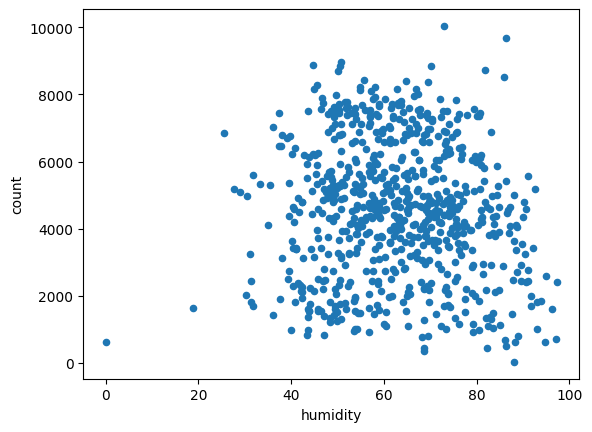

In [ ]:
df.plot(x='humidity', y='count', kind='scatter');

**Why not look at all features?**

First get a list of all the potential predictor columns and see how many there are.

In [ ]:
# Get a list of all columns excluding the response 'count'
cols = df.drop('count', axis=1).columns

# There are 10 features
# This is a nice even number for plotting in a grid with 2 columns
print(f"There are {len(cols)} potential predictors.\nThey are {cols.values}." )

There are 10 potential predictors.
They are ['season' 'month' 'holiday' 'day_of_week' 'workingday' 'weather' 'temp'
 'atemp' 'humidity' 'windspeed'].


Now, with the help of `plt.subplots()`, create a grid of scatter plots showing the relationship between each potential predictor and `count`.

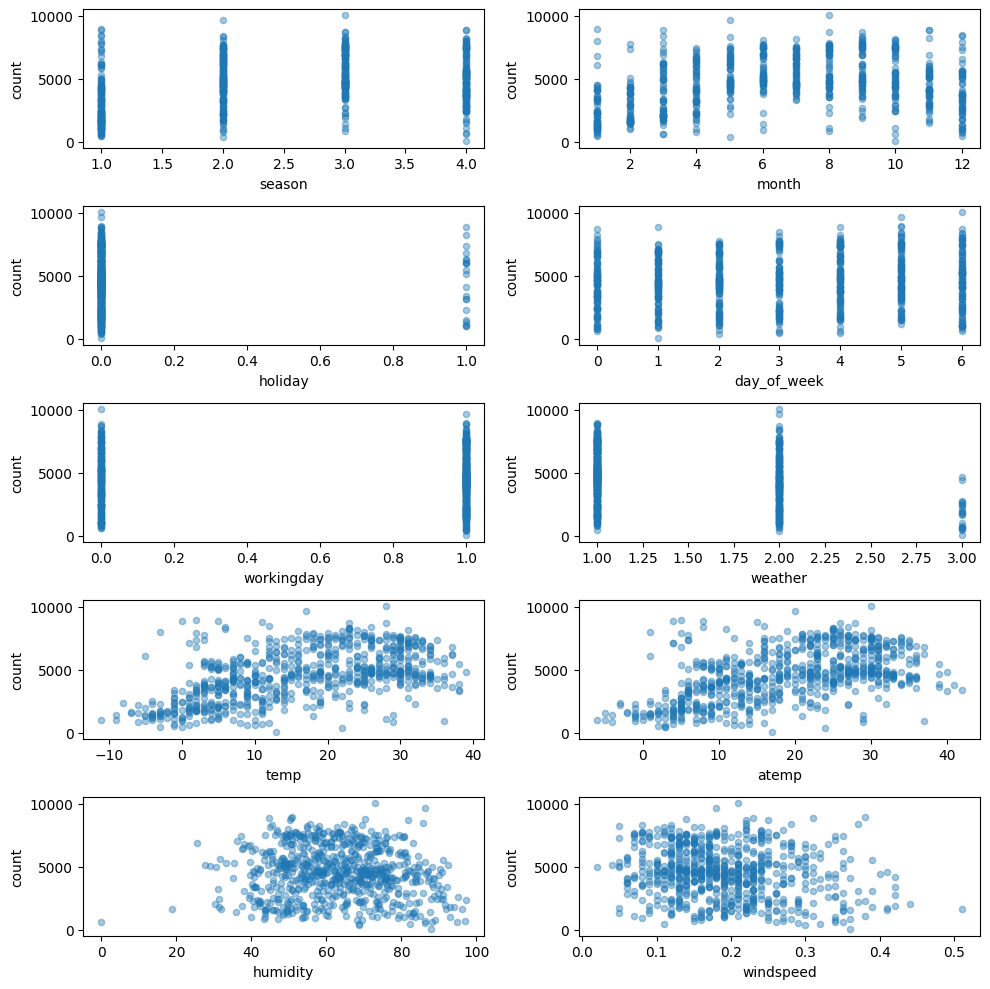

In [ ]:
import matplotlib.pyplot as plt
# Create a grid of axes
fig, axes = plt.subplots(nrows=len(cols)//2, ncols=2, figsize=(10,10))
# flatted the axes array to 1D
axes = axes.ravel()
# iterate over pairs of column names and axes
for c, ax in zip(cols, axes):
    # Use pandas' plot functionality
    df.plot(x=c, y='count', kind='scatter', ax=ax, alpha=0.4)
# add some padding between subplots
plt.tight_layout()

Seaborn's `pairplot` method allows us to do something very similar with very little code.

But with a DataFrame with $M$ columns you get a huge plot of all $M\times M$ relationships! We can use the `x_vars` and/or `y_vars` arguments to list only those variables to include on each axis.

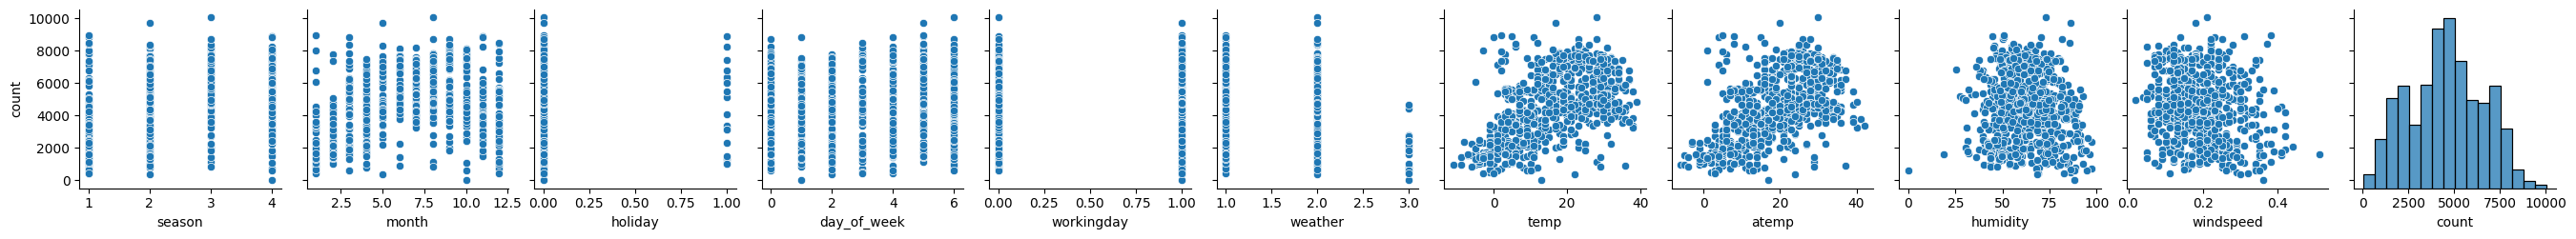

In [ ]:
# %load snippets/pairplot.py
# x_vars and y_vars args help slim it down
sns.pairplot(df, y_vars=['count']);

Another approach is to visualize the correlation between each predictor.

We can get the correlation coefficients with the `corr()` DataFrame method and then use Seaborn's `heatmap()` to vizualize the values.

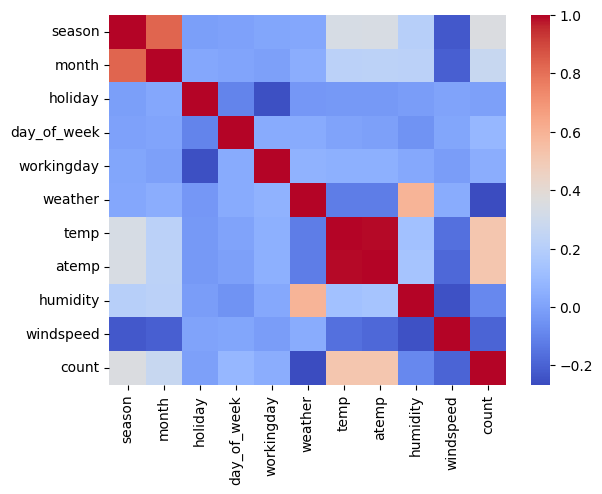

In [ ]:
# visualizing the correlation between all variables
import seaborn as sns
sns.heatmap(df.corr(), cmap='coolwarm'),;

It looks like `temp` is the winner.

**Q:** 🤔 Is there a way we could change the heatmap to make it easier to interpret?

### Feature engineering: `temp_bin`

Let's engineer a new feature called **`temp_bin`** by **binning the continuous temperature** (`temp`) into 5 categories:

- `<0` (below freezing)  
- `0–10` (cold)  
- `10–20` (cool/mild)  
- `20–30` (warm)  
- `30+` (hot)



In [ ]:
# Create a multi-class predictor column (preview for multinomial later)
df['temp_bin'] = pd.cut(
    df['temp'],
    bins=[-50, 0, 10, 20, 30, 60],
    labels=['<0','0–10','10–20','20–30','30+'],
    right=False
)
df['temp_bin'].value_counts().sort_index()

,count
temp_bin,
<0,52
0–10,195
10–20,174
20–30,187
30+,123


Why do this?
- It’s **feature engineering**: a way to model **nonlinear** patterns with a simple linear model.
- A straight line in °C may miss “sweet spots” (e.g., riding peaks on warm days but drops on very hot days).
- Turning `temp` into **categories** lets linear regression learn **different baselines** per bin (via one-hot encoding, which we will get to soon).

We’ll **keep using numeric `temp`** for the single-feature demos, and later (multivariate section) we’ll use **`temp_bin`** as a categorical predictor.


Later, when we do multivariate regression with one-hot encoding, we can include temp_bin as an additional predictor. That way the model can learn different rental levels for each temperature category.

### We have our favorite predictor, `temp`. Now what?

Now let's separate our chosen predictor and the response variable into `x` and `y`.

You may want to check the data types of your new variables so you know what you're working with.

In [ ]:
x = df[['temp']]
y = df['count']
type(x), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

Check the shapes!

In [ ]:
x.shape, y.shape

((731, 1), (731,))

SKLearn models expect the predictors, $X$, to be in the form of a matrix. That is, there should be an explicit 2nd dimension. One way to handle this requirement is to use the double-brackets when indexing into your DataFrame to so you get a DataFrame back (and not a Series). If you are dealing with a 1D Numpy array, you can add a second dimension with the `reshape` or `expand_dims` methods.

#### Train-Test Split

We might be tempted to jump right to model fitting, but hold your horses! ✋🐎

If we use all of our data for training we are then forced to *evaluate* the model on the same data it was trained on!

But we want some sense of how well the model will **generalize**. That is, how well it performs on previously unseen data.

A low loss on the training data does not guarantee good generalization. The model may have fit to the idiosyncrasies of our *particular* training data (noise, outliers, etc.) that are not representative of the wider population of potential data points. This would be a case of the dreaded **overfitting**.

So let's split our dataset into two pieces. A **train set** which we will use to fit the model, and a **test set** used for evaluating the model after fitting. (We will get to the validation soon, in the kNN section.)

We'll be using a lot of classes and methods from the [sklearn](https://scikit-learn.org/stable/index.html) library both for our models themselves as well as helper functions for splitting and metrics.

SKLearn functions and classes are grouped into different modules within the library. Search the [sklearn documentation](https://scikit-learn.org/stable/modules/classes.html) for "train test split" in order to see what module the relevent function resides in. This will tell us how we can import it! You can of course all read the full documentation on the function itself there.

In [ ]:
from sklearn.model_selection import train_test_split

It is important to shuffle the data (`shuffle=True` by default) to ensure a random sample for the test data.

Setting the `random_state` allows for reproducible results, ensuring we get the same split each time the code is run.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, shuffle=True, random_state=209)

Again, inspecting shapes can be helpful if you aren't sure you named the output correctly.

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((584, 1), (147, 1), (584,), (147,))

We can also visually inspect that the split was random.

Create a scatter plot of temp vs count where train and test data are given different colors.

You should always use a **legend** to designate the meaning of each color. Also, adjusting the **alpha** value can be helpful to see where points are densly clustered.

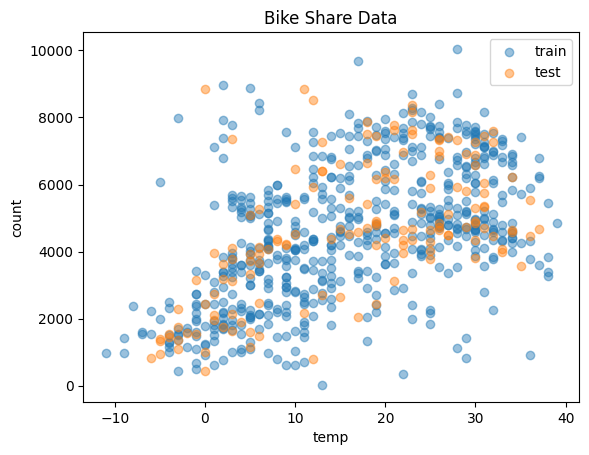

In [ ]:
plt.scatter(x_train, y_train, alpha=0.45, label='train')
plt.scatter(x_test, y_test, alpha=0.45, label='test')
plt.xlabel('temp')
plt.ylabel('count')
plt.title('Bike Share Data')
plt.legend();

### Simple Linear Regression

Import the `LinearRegression` class from sklearn's `linear_model` module.

In [ ]:
from sklearn.linear_model import LinearRegression

Fit a linear regression (on the train data of course!)

In [ ]:
lr = LinearRegression().fit(x_train, y_train)

Inspect the learned model parameters.

In [ ]:
lr.intercept_, lr.coef_

(np.float64(3101.4328702768553), array([88.55680006]))

We can get the same model parameters using the linear algebra Pavlos showed in lecture.\
$$\beta = (X^{\top}X)^{-1}X^{\top}Y$$

Just remember that we actually need to augment our $x$ vector into a matrix with a column of ones if we want an intercept ($\beta_0$) term (consult the lecture 5 slides for details).

We can can store the augmented `x_train` as `X`. There are many ways to do this. One is to use a combination of `np.ones_like()` and `np.hstack()`.

In [ ]:
import numpy as np
X = np.hstack((np.ones_like(x_train), x_train))
X

array([[ 1., 18.],
       [ 1., 33.],
       [ 1.,  2.],
       ...,
       [ 1., 31.],
       [ 1.,  2.],
       [ 1., 26.]])

Then it is just a matter of performing the matrix operations shown in the $\LaTeX$ above!

Compare the resulting $\beta$ values to the ones returned by SKLearn.

In [ ]:
betas = np.linalg.inv(X.T@X)@X.T@y_train
betas

array([3101.43287028,   88.55680006])

#### Model Evaluation

Let's calculate the train MSE. This will require predictions. You get these by calling the model's `predict` method on the appropriate data.

First, calculate the MSE by hand...

In [ ]:
y_hat_train = lr.predict(x_train)
((y_train - y_hat_train)**2).mean()

np.float64(3054019.3409423027)

...then again but this time with the help of sklearn's `mean_squared_error` method from the `metrics` module.

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, y_hat_train)

3054019.3409423027

Now calculate the test MSE!

In [ ]:
y_hat_test = lr.predict(x_test)

mean_squared_error(y_test, y_hat_test)

2757704.6531113624

Are these good or bad MSEs? It is hard to make that kind of judgement given that they depend on the scale of the response variable.

Instead, we can use the **$R^2$ score** which compares out model to a baseline model which always predits the mean response value.

Recall that $R^2 = 1 - \frac{\text{unexplained variation}}{\text{total variation}}$

Calculate the $R^2$ score on the test data. First by hand...

In [ ]:
total_var = sum((y_test.mean() - y_test)**2)
unexp_var = sum((y_test - y_hat_test)**2)
1 - (unexp_var/total_var)

0.32439229345357057

...and again using the `r2_score` metric from sklearn.

In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test, y_hat_test)

0.32439229345357057

Sklearn models ('estimators' in their parlance) have a standardized API which include common methods like `fit` and `predict`.

There is also a `score` method which will return a (model dependent) metric when given an $x$ and $y$. This metric happens to be the $R^2$ for both the `LinearRegression` and `KNeighborsRegressor` estimators.

Under the hood it is making predictions and then comparing those to the true $y$ values.

Use your model's `score` to get the $R^2$ score on the test data.

In [ ]:
lr.score(x_test, y_test)

0.32439229345357057

#### D.R.Y: Don't Repeat Yourself

Let's make a function to help calculate metrics for our models since we will do this multiple times in the notebook.

The `get_metrics` below returns a dictionary containing the requested information about the input model.

In [ ]:
def get_metrics(model, name: str, data: tuple) -> dict:
    '''
    Parameters
    ----------
    model : (sklearn estimator) This is your fitted sklearn model
    name : (str) A name to represent your model
    data : (tuple) contains train and test split for x and y

    Returns:
    metrics : (dict) should have entries for:
             name, train_mse, test_mse, r2_train, and r2_test
    '''
    x_train, x_test, y_train, y_test = data
    # your code here
    d = {}
    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)
    d['name'] = name
    d['train_mse'] = mean_squared_error(y_train, y_hat_train)
    d['test_mse'] = mean_squared_error(y_test, y_hat_test)
    d['r2_train'] = r2_score(y_train, y_hat_train)
    d['r2_test'] = r2_score(y_test, y_hat_test)
    return d

We'll keep track of our models' results using a list of dictionaries.

Use `get_metrics` to calculate the metrics for your linear regression model and add it to a list called `results`.

In [ ]:
data = (x_train, x_test, y_train, y_test)
results = [get_metrics(lr, 'Linear Regression', data)]
results

[{'name': 'Linear Regression',
  'train_mse': 3054019.3409423027,
  'test_mse': 2757704.6531113624,
  'r2_train': 0.2517207811009071,
  'r2_test': 0.32439229345357057}]

This also allows us to display the results in a nice DataFrame. OooOoo!

Use `results` to create a DataFrame.

In [ ]:
pd.DataFrame(results)

,name,train_mse,test_mse,r2_train,r2_test
0,Linear Regression,3.054019e+06,2.757705e+06,0.251721,0.324392


####  Visualizing our model

The metrics above give us information about the model's performance. But a picture can also help our understanding.

Let's create a plot showing the train data, test data, and model predictions *for all values of the predictor in the range of the dataset*.

First, use `np.linspace` to create an array of equally spaced values spanning the range of temperatures observed in the entire dataset. Store these values in `x_lin`.

In [ ]:
# create a range of values to predict on
x_lin = np.linspace(x.min(), x.max(), 1000)

# If the model was fit on data with a names for the predictor(s)
# (e.g., a Series or DataFrame)
# and is then asked to predict on data with no names
# (e.g., a numpy array)
# it will complain!
# These warnings are harmless but ugly :(
# One way to get it to shush is to turn the data into a type
# that does include a name for the predictor(s)
x_lin = pd.DataFrame(x_lin, columns=['temp'])
x_lin.head()

,temp
0,-11.00000
1,-10.94995
2,-10.89990
3,-10.84985
4,-10.79980


Now the actual plot!

Overlay the model's prediction line on top of a scatter plot of the train and test data (you can recycle that plotting code form earlier).

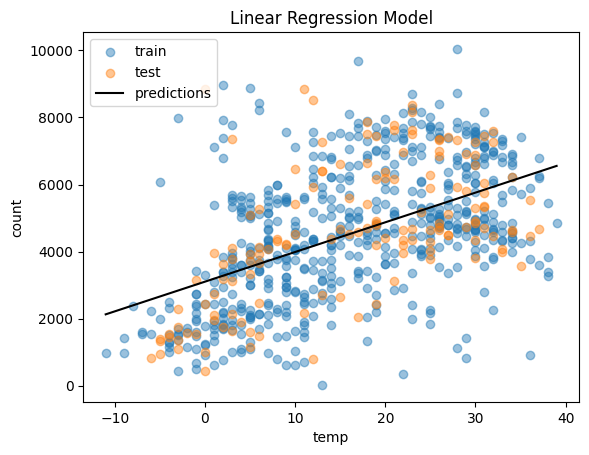

In [ ]:
y_pred = lr.predict(x_lin)
plt.scatter(x_train, y_train, alpha=0.45, label='train')
plt.scatter(x_test, y_test, alpha=0.45, label='test')
plt.plot(x_lin, y_pred, c='k', label='predictions');
plt.xlabel('temp')
plt.ylabel('count')
plt.title('Linear Regression Model')
plt.legend();

#### Exercise 1: Linear model assumptions

Pavlos told us in lecture (or will tell us in lecture) that two of our assumptions when using a linear model are that (1) the variance of the residuals is constant and (2) the residuals are normally distributed. Let's check those assumptions.

**Is the variance of the residuals constant across temperatures?**

First, we'll check for constant variance of the residuals. Recall that the residuals are the difference between the true value and the predicted value: $r = y_{true} - y_{predicted}$.

Calculate the residuals on the test data and plot them on a scatter plot. Add a horizontal line at `y=0` to your scatter plot with the code with the line `plt.axhline(0, c='k')`.

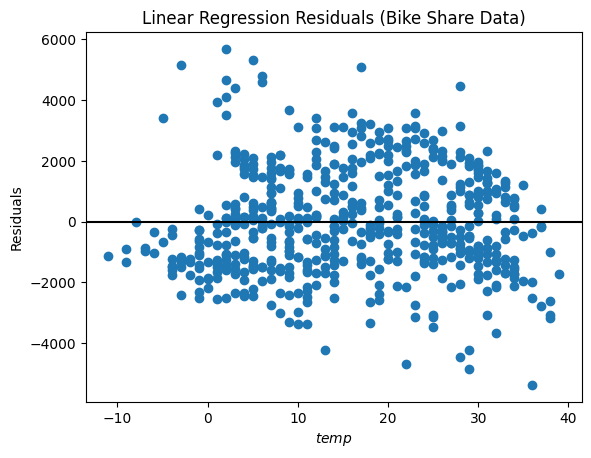

In [ ]:
### SOLUTION
y_hat_train = lr.predict(x_train)
resids = y_train - y_hat_train

plt.scatter(x_train, resids)
plt.axhline(0, c='k')
plt.ylabel('Residuals')
plt.title('Linear Regression Residuals (Bike Share Data)')
plt.xlabel('$temp$');

**Are the residuals normally distributed?**

Next, plot the residuals on a histogram to visualize their distribution.

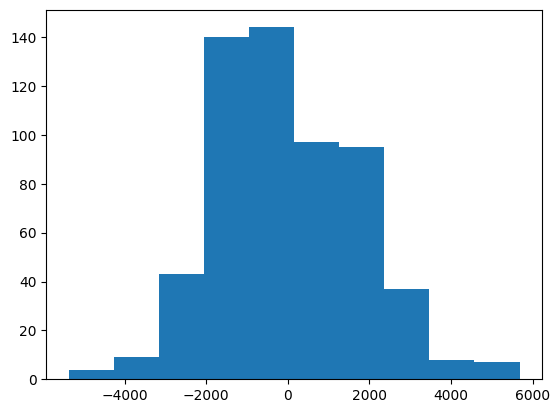

In [ ]:
# Your code here (plot a histogram of residuals.)
plt.hist(resids);

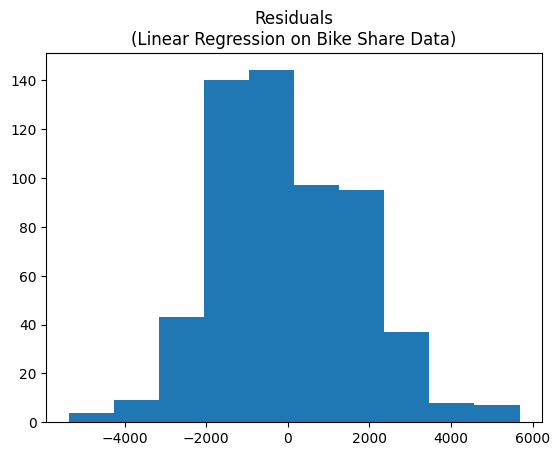

In [ ]:
### SOLUTION

plt.hist(resids);
plt.title('Residuals\n(Linear Regression on Bike Share Data)');

If we look back at our plot of the training data we can see there is a slight curve in the trend. We might have expected this: bike riding increases as the tempature increases, but only up to a point. At some point the heat makes people less inclined to go for a ride! 🚴‍♀️🌞

Perhaps a linear model with engineered features or a non-linear model like kNN may be better suited to model the relationship between `temp` and `count`.

### Multivariable Linear Regression:

So far we only used one predictor. Now we can try to use all predictors at once, both categorical and numeric.

**Step 1 — Select predictors and response variables.**

In [ ]:
response = 'count'
categorical_cols = ['season','month','holiday','day_of_week','workingday','weather','temp_bin']
numeric_cols     = ['temp','atemp','humidity','windspeed']

X = df[categorical_cols + numeric_cols]
y = df[response]


NameError: name 'df' is not defined

In [ ]:
X['temp_bin'].value_counts()

,count
temp_bin,
0–10,195
20–30,187
10–20,174
30+,123
<0,52


**Step 2 — One-hot encode categorical columns with pandas**

This is where the “dummy variables” come in: we turn each category into its own 0/1 column.

In [ ]:
X_dummies = pd.get_dummies(X, columns=["season", "month", "day_of_week", "weather", "temp_bin"])
X_dummies.columns


Index(['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'season_1', 'season_2', 'season_3', 'season_4', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'weather_1', 'weather_2', 'weather_3',
       'temp_bin_<0', 'temp_bin_0–10', 'temp_bin_10–20', 'temp_bin_20–30',
       'temp_bin_30+'],
      dtype='object')

**Step 3 — Scale numerical variables by converting them to z-scores.**

This is important if we want to  compare the influence of different predictors after creating the model (which we will be doing in step 6!)

In [ ]:
# Standardize numeric features
X_numeric = X_dummies[['temp','atemp','humidity','windspeed']]
X_numeric_standardized = (X_numeric - X_numeric.mean()) / X_numeric.std()

# Alternative approach using StandardScaler
scaler = StandardScaler() # create a scaler
# 'fit' learns mean and std; 'transform' uses them to standardize (returns np array)
X_numeric_standardized_np = scaler.fit_transform(X_numeric)
# Make the np array a DataFrame again using the original column names
X_numeric_standardized = pd.DataFrame(X_numeric_standardized_np, columns=X_numeric.columns)

X_dummies['temp'] = X_numeric_standardized['temp']
X_dummies['atemp'] = X_numeric_standardized['atemp']
X_dummies['humidity'] = X_numeric_standardized['humidity']
X_dummies['windspeed'] = X_numeric_standardized['windspeed']

X_dummies.head()

,holiday,workingday,temp,atemp,humidity,windspeed,season_1,season_2,season_3,season_4,...,day_of_week_5,day_of_week_6,weather_1,weather_2,weather_3,temp_bin_<0,temp_bin_0–10,temp_bin_10–20,temp_bin_20–30,temp_bin_30+
0,0,1,0.674307,0.692689,0.968908,-0.906690,False,True,False,False,...,False,False,False,True,False,False,False,False,True,False
1,0,1,-0.106726,0.011187,0.744081,-0.262579,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
2,0,1,0.847869,0.887403,-0.409561,0.767999,False,True,False,False,...,False,False,True,False,False,False,False,False,True,False
3,0,0,-1.408446,-1.449172,-0.292230,-0.262579,False,False,False,True,...,False,False,True,False,False,False,True,False,False,False
4,0,1,0.587525,0.400617,2.031918,-1.164335,False,False,True,False,...,False,False,False,False,True,False,False,False,True,False


**Step 4 — Train/test split.**

In [ ]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
    X_dummies, y, test_size=0.3, random_state=42, shuffle=True
)


**Step 5 — Fit a Regression model.**

We can use LinearRegression as we did before and inspect its performance:

In [ ]:
from sklearn.linear_model import LinearRegression

lr_multi = LinearRegression().fit(X_tr, y_tr)

# Add to the results dataframe and print to view
data = (X_tr, X_te, y_tr, y_te)
results.append(get_metrics(lr_multi, 'Multi linear regression', data))

pd.DataFrame(results)

,name,train_mse,test_mse,r2_train,r2_test
0,Linear Regression,3.054019e+06,2.757705e+06,0.251721,0.324392
1,Multi linear regression,2.242762e+06,2.430930e+06,0.468815,0.352806


**Step 6 — Inspect the coefficients of the trained model:**

In [ ]:
coef = pd.Series(lr_multi.coef_, index=X_dummies.columns)
coef.sort_values(key=abs, ascending=False)


,0
temp_bin_<0,-1953.463949
weather_3,-1568.262638
temp_bin_20–30,1349.604590
temp_bin_30+,1005.871098
weather_1,957.377696
temp_bin_0–10,-874.262041
weather_2,610.884942
temp,534.850128
atemp,-514.171094
temp_bin_10–20,472.250302


**Step 7 — Check the residuals:**

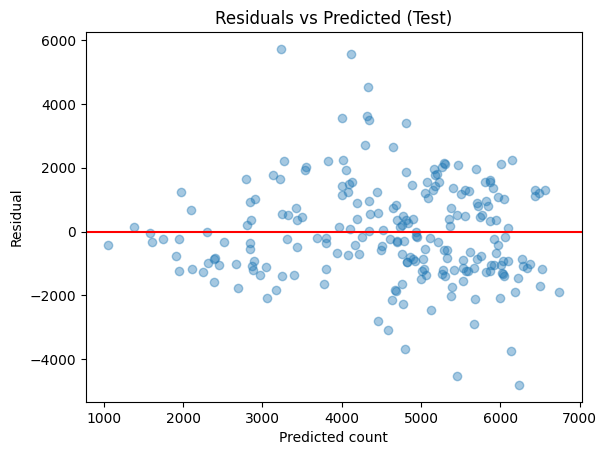

In [ ]:
yhat_te = lr_multi.predict(X_te)
resids = y_te - yhat_te

import matplotlib.pyplot as plt
plt.scatter(yhat_te, resids, alpha=0.4)
plt.axhline(0, color='red')
plt.xlabel("Predicted count")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted (Test)")
plt.show()


### Interpreting Results: Coefficients

- **Coefficients (betas)**  
  These come from the linear regression after one-hot encoding and scaling.  
  They tell us the *direction and size of association* for each predictor (holding others constant).  
  - Positive coefficients → *increase predicted rentals*  
  - Negative coefficients → *decrease predicted rentals*  
  - Examples:  
    - `temp_bin_20–30 ≈ +1350` → warm days (20–30°C) are linked with ~1350 more rentals compared to the baseline bin (0–10°C).  
    - `temp_bin_<0 ≈ –1950` → below-freezing days reduce rentals by about 1950.  
    - `weather_3 ≈ –1600` → snow/rain days cut rentals by ~1600 compared to clear days.  


🤔 **Discussion Question:**  
Why might `temp_bin` show up as more important than `temp` itself?  
When could binning a continuous variable actually help a linear model?


## kNN Regression

Unlike linear regression, kNN regression does not calculate any parameters. It simply stores the training data in an efficient way for calculating pair-wise distances at prediction time.

While kNN regression does not involve any parameters, it does require us to choose a *hyperparameter*, `k`. Hyperparameters are *not* learned from the data. Instead, they are set by the practitioner (like you!) and define the learning/prediction algorithm that will follow.

### Parameters vs. Hyperparameters (don’t mix these up!)

- **Parameters** are **learned from data** during training.
  - Example here: the **β coefficients** of **Linear Regression**.
- **Hyperparameters** are **set by you** (and tuned via validation/CV), not learned.
  - Example here: **`k`** (the number of neighbors) in **kNN**.

**Why it matters:**  
- We **optimize parameters** by fitting on the **train set**.  
- We **choose hyperparameters** (like `k`) by checking performance on a **validation set** (or via cross-validation), **not** on the test set.  
- The **test set** is for **one final, honest evaluation** after all choices are made and models are trained
.


Fit a kNN model using the `sklearn.neighbors.KNeighborsRegressor` class. To start, let's use `n_neighbors=10` and our previous `x_train` and `y_train`.


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=10).fit(x_train, y_train)

Now let's plot our kNN model's predictions. We will again need to use something like `np.linspace` to generate inputs for the predictions. Remember that the kNN predictions should look like a step function; there should be no diagonal sections. If you see diagonal portions of the prediction line then you are not using a sufficient number of points in your linspace.

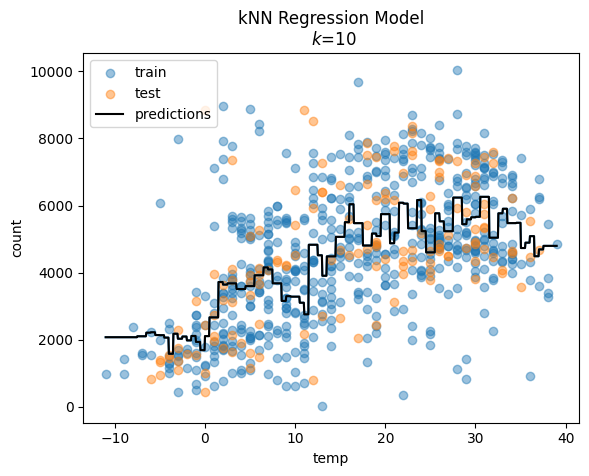

In [ ]:
# generate x values to predict on as before (for completeness)
x_lin = np.linspace(x.min(), x.max(), 1000)
x_lin = pd.DataFrame(x_lin, columns=['temp'])
x_lin.head()

# get predictions to plot
y_pred = knn.predict(x_lin)

# plot!
plt.plot(x_lin, y_pred)
plt.scatter(x_train, y_train, alpha=0.45, label='train')
plt.scatter(x_test, y_test, alpha=0.45, label='test')
plt.plot(x_lin, y_pred, c='k', label='predictions');
plt.xlabel('temp')
plt.ylabel('count')
plt.title(f'kNN Regression Model\n $k$=10')
plt.legend();

Use `get_metrics` to calculate the kNN model's metrics, append them to `results`, and display `results` as a DataFrame.

In [ ]:
data = (x_train, x_test, y_train, y_test)
results.append(get_metrics(knn, 'kNN single var (k=10)', data))

pd.DataFrame(results)

,name,train_mse,test_mse,r2_train,r2_test
0,Linear Regression,3.054019e+06,2.757705e+06,0.251721,0.324392
1,Multi linear regression,2.242762e+06,2.430930e+06,0.468815,0.352806
2,kNN single var (k=10),2.762319e+06,2.780965e+06,0.323192,0.318694


### Choosing $k$

OK, great! But $k=10$ was an arbitrary choice. Should we choose the $k$-value that minimizes the test MSE?

**No**, we should not choose use the test set to choose $k$! The test set should only be used after all models are designed and trained, purely for the purpose of evaluation. This means *both* hyperparameters and parameters should be determined before accessing the test set. What are we to do?

We address this issue by introducing a third set, the **validation set**, for hyperparameter selection.

**Correct workflow for choosing k:**  
1. Split data into **train**, **validation**, and **test** (e.g. 60/20/20).  
2. Use the **train** set to fit models.  
3. Use the **validation** set to compare hyperparameters (like `k`).  
4. Once we’ve chosen the best `k`, do **one final evaluation** on the untouched **test set**.  

Let's implement a train/validation/test set split using temperature as the only predictor variable (`temp`).

In [ ]:
# 60/20/20 split: first carve out a final test set, then a validation set from the remainder
x_train_and_val, x_test_final, y_train_and_val, y_test_final = train_test_split(
    x, y, test_size=0.20, random_state=42, shuffle=True
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_and_val, y_train_and_val, test_size=0.25, random_state=42, shuffle=True
)  # 0.25 of 0.80 -> 0.20, so 60/20/20 total

### Exercise 2: Determine optimal k

Determine the k value with the lowest MSE on the validation set. Train kNN regressors with k values ranging from 1 to 100 and inspect the validation loss as a function of $k$ (i.e., plot MSE versus $k$). Store the train and test MSEs for each model.

In [ ]:
ks = range(1, 101)
train_mses, val_mses = [], []

for k in ks:
    ... # write code to populate train_mses and val_mses for k = 1 to 100

In [ ]:
### SOLUTION
for k in ks:
    model = KNeighborsRegressor(n_neighbors=k).fit(x_train, y_train)
    train_mses.append(mean_squared_error(y_train, model.predict(x_train)))
    val_mses.append(mean_squared_error(y_val,   model.predict(x_val)))

In [ ]:
best_k_val = ...

In [ ]:
### SOLUTION
best_k_val = ks[int(np.argmin(val_mses))]

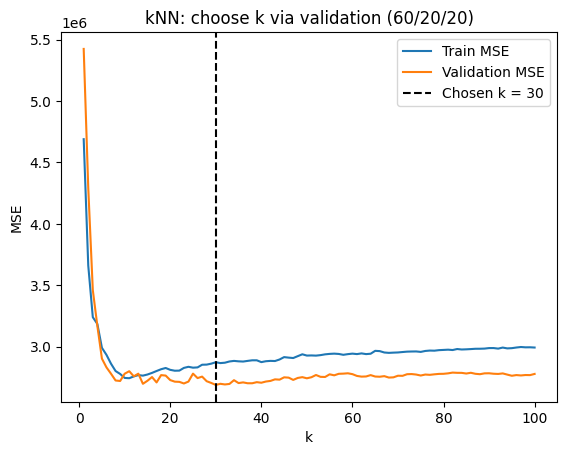

In [ ]:
# Plot Train vs Validation MSE and mark chosen k
plt.plot(ks, train_mses, label='Train MSE')
plt.plot(ks, val_mses,   label='Validation MSE')
plt.axvline(best_k_val, ls='--', c='k', label=f'Chosen k = {best_k_val}')
plt.xlabel('k'); plt.ylabel('MSE'); plt.title('kNN: choose k via validation (60/20/20)')
plt.legend(); plt.show()

Create a visualization comparing the predictions of several different kNN models, each using different value of $k$. Use values of $k=$ 1, 2, 4, 8, 16, 32, 64, and 128.
Note: it would be wise to use `plt.subplots` for visualization here.

In [ ]:
# Your code to visualize kNN model predictions for k=1, 2, 4, 8, 16, 32, 64, and 128


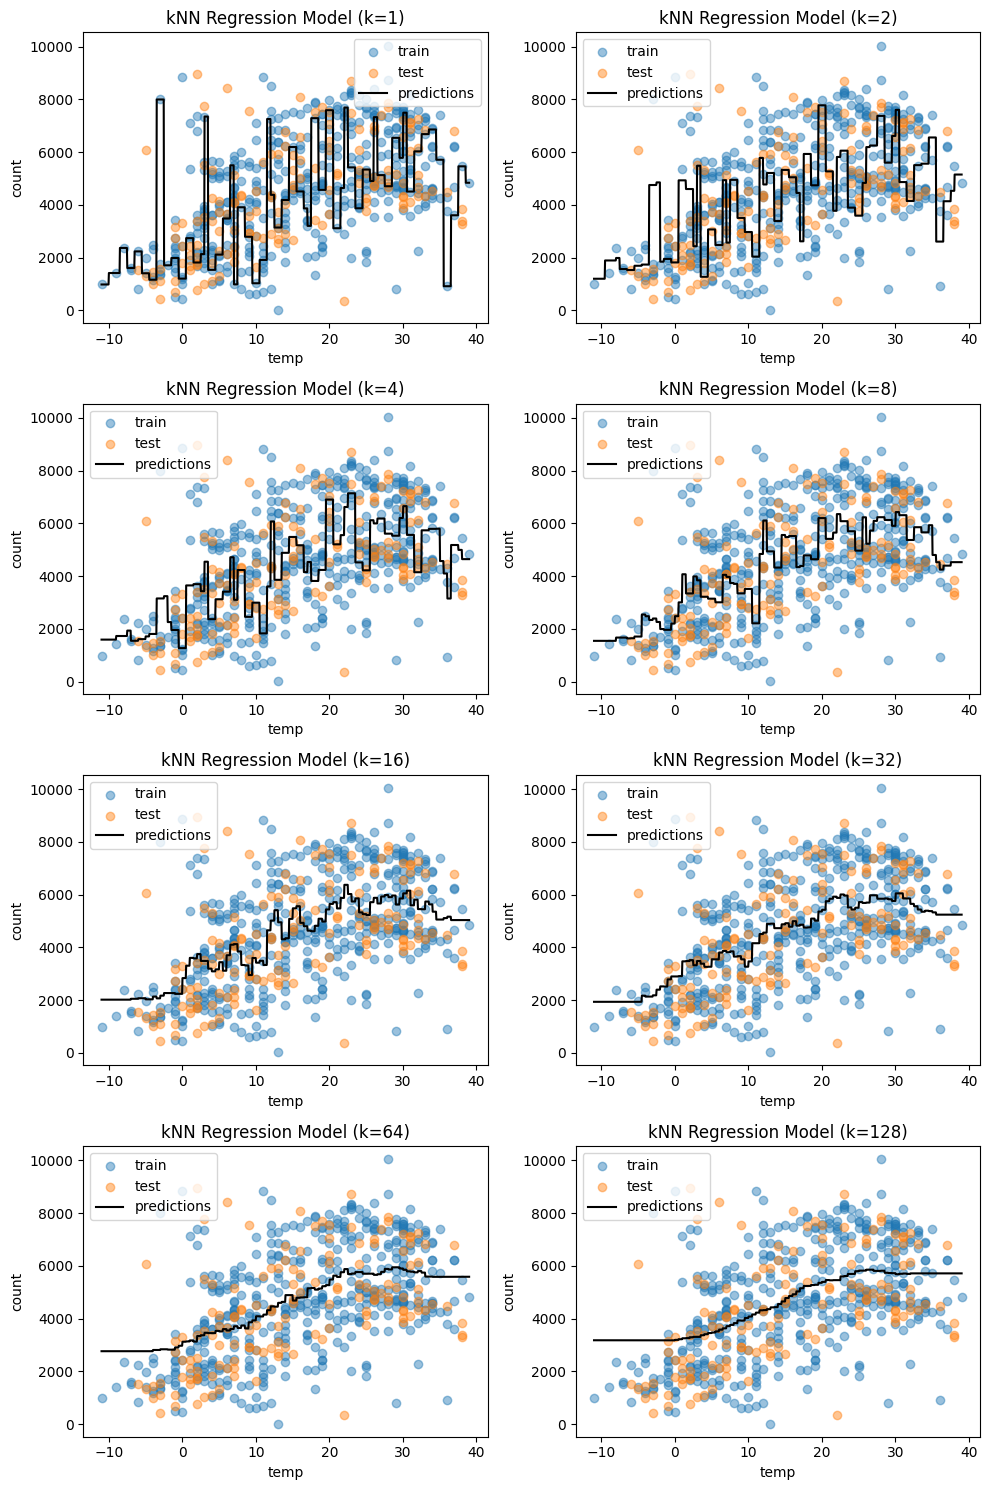

In [ ]:
### SOLUTION
# 'fit' a model for each k and collect the predictions
ks = [2**x for x in range(0,8)]
all_preds = []
for k in ks:
    preds = KNeighborsRegressor(n_neighbors=k).fit(x_train, y_train).predict(x_lin)
    all_preds.append(preds)

fig, axes = plt.subplots(nrows=len(all_preds)//2, ncols=2, figsize=(10,15))
axes = axes.ravel()
# We can zip as many iterables as we like together!
for k, cur_preds, ax in zip(ks, all_preds, axes):
    ax.scatter(x_train, y_train, alpha=0.45, label='train')
    ax.scatter(x_val, y_val, alpha=0.45, label='test')
    ax.plot(x_lin, cur_preds, c='k', label='predictions');
    ax.set_xlabel('temp')
    ax.set_ylabel('count')
    ax.set_title(f'kNN Regression Model (k={k})')
    ax.legend();

plt.tight_layout()

In [ ]:
# Append the kNN performance results to the results dictionary
final_knn = KNeighborsRegressor(n_neighbors=best_k_val).fit(x_train, y_train)
test_mse = mean_squared_error(y_test_final, final_knn.predict(x_test_final))
test_r2  = r2_score(y_test_final, final_knn.predict(x_test_final))

data = (x_train, x_test_final, y_train, y_test_final)
results.append(get_metrics(final_knn, f'kNN single var (k={best_k_val})', (data)))

pd.DataFrame(results)

,name,train_mse,test_mse,r2_train,r2_test
0,Linear Regression,3.054019e+06,2.757705e+06,0.251721,0.324392
1,Multi linear regression,2.242762e+06,2.430930e+06,0.468815,0.352806
2,kNN single var (k=10),2.762319e+06,2.780965e+06,0.323192,0.318694
3,kNN single var (k=30),2.874033e+06,2.663214e+06,0.318659,0.256625


Some questions to consider...

**Q:** How does MSE trend with k after the optimal `k` value? Why do you think this is the case? 🤔

**Q:** Might we be justified in choosing a $k$ that does not produce the lowest test score? 🤔

**Q:** Do you have any reason to be skeptical about using the test score to determine the best $k$? 🤔

### Exercise 3: Multivariate kNN

Our kNN model above only considered one predictor: temperature. For Exercise 3, build a kNN model that takes the four numeric predictors as inputs. In the space below, identify the optimal k when the four numeric inputs are used. (Reminder: Begin by doing a train-validation-test split.)



In [ ]:
numeric_cols = ['temp','atemp','humidity','windspeed']
X_numeric = df[numeric_cols]
y_numeric = df[response]

ks = range(1, 101)
train_mses, val_mses = [], []

# Your code here


best_k_val = ...

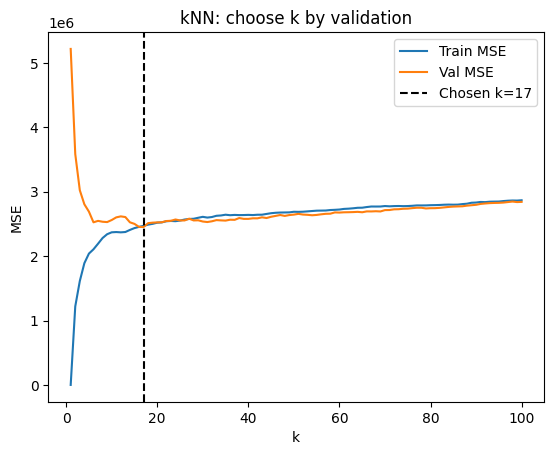

Final Test MSE: 2362699.285737825
Final Test  R²: 0.34050693189611647


In [ ]:
### SOLUTION
ks = range(1, 101)
train_mses, val_mses = [], []

# 60/20/20 split: first carve out a final test set, then a validation set from the remainder
X_temp, X_test_final, y_temp, y_test_final = train_test_split(
    X_numeric, y_numeric, test_size=0.20, random_state=42, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, shuffle=True
)  # 0.25 of 0.80 -> 0.20, so 60/20/20 total

for k in ks:
    m = KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train)
    train_mses.append(mean_squared_error(y_train, m.predict(X_train)))
    val_mses.append(mean_squared_error(y_val, m.predict(X_val)))

best_k_val = ks[int(np.argmin(val_mses))]

plt.plot(ks, train_mses, label='Train MSE')
plt.plot(ks, val_mses,   label='Val MSE')
plt.axvline(best_k_val, ls='--', c='k', label=f'Chosen k={best_k_val}')
plt.xlabel('k'); plt.ylabel('MSE'); plt.title('kNN: choose k by validation'); plt.legend(); plt.show()

# One-shot evaluation on the untouched test
final_knn = KNeighborsRegressor(n_neighbors=best_k_val).fit(X_val, y_val)
print("Final Test MSE:", mean_squared_error(y_test_final, final_knn.predict(X_test_final)))
print("Final Test  R²:", r2_score(y_test_final, final_knn.predict(X_test_final)))


#### Response Surface
We can also visualize multiple variables on a "response surface" representing the kNN regressor's output across a grid of predictor values. The code below will generate a response surface visualizing the impact of `temp` and `humidity ` on the model output.

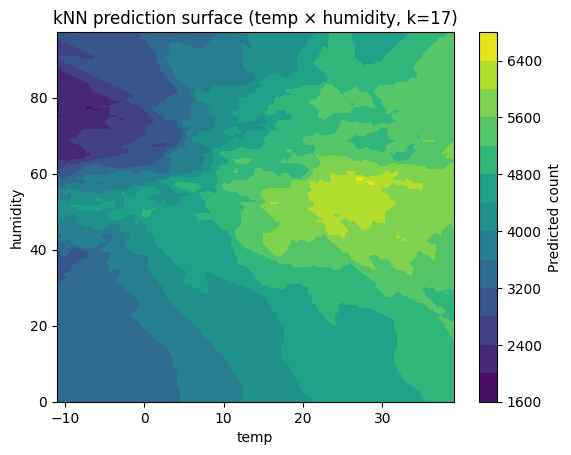

In [ ]:
# Visualize prediction surface for temp × humidity using multivariate kNN pipeline
f1, f2 = 'temp', 'humidity'

n1 = np.linspace(df[f1].min(), df[f1].max(), 120)
n2 = np.linspace(df[f2].min(), df[f2].max(), 120)
g1, g2 = np.meshgrid(n1, n2)
Xg = pd.DataFrame({f1: g1.ravel(), f2: g2.ravel()})

# fill remaining features at typical values
for c in numeric_cols:
    if c not in [f1, f2]: Xg[c] = df[c].median()

Xg = Xg[X_numeric.columns]

Z = final_knn.predict(Xg).reshape(g1.shape)
cs = plt.contourf(g1, g2, Z, levels=14)
plt.colorbar(cs, label='Predicted count')
plt.xlabel(f1); plt.ylabel(f2); plt.title(f'kNN prediction surface ({f1} × {f2}, k={best_k_val})')
plt.show()


#### Final metric comparison
Fit the best kNN model, calculate and append its metrics to `results`, and again display all model results as a DataFrame.

In [ ]:
data_multi_knn = (X_train, X_test_final, y_train, y_test_final)
results.append(get_metrics(final_knn, f'kNN multi (k={best_k_val})', data_multi_knn))
pd.DataFrame(results)

,name,train_mse,test_mse,r2_train,r2_test
0,Linear Regression,3.054019e+06,2.757705e+06,0.251721,0.324392
1,Multi linear regression,2.242762e+06,2.430930e+06,0.468815,0.352806
2,kNN single var (k=10),2.762319e+06,2.780965e+06,0.323192,0.318694
3,kNN single var (k=30),2.874033e+06,2.663214e+06,0.318659,0.256625
4,kNN multi (k=17),2.839555e+06,2.362699e+06,0.326833,0.340507


**Bonus:** Try changing the `random_state` in the call to `train_test_split` and see how it affects your results, both in regards to the metrics and the choice of best $k$. It seems our results are sensitive to the random test split we received! This motivates the idea of **cross-validation** which will be covered next week!

In [ ]:
def single_feature_compare(feature, yname='count', k=11, seed=43):
    Xf = df[[feature]].to_numpy()
    yf = df[yname].to_numpy()
    X_trf, X_tef, y_trf, y_tef = train_test_split(Xf, yf, test_size=0.3, random_state=seed, shuffle=True)
    lr = LinearRegression().fit(X_trf, y_trf)
    knn = KNeighborsRegressor(n_neighbors=k).fit(X_trf, y_trf)
    return {
        'feature': feature,
        'LR_test_MSE': mean_squared_error(y_tef, lr.predict(X_tef)),
        'LR_test_R2':  r2_score(y_tef, lr.predict(X_tef)),
        f'kNN(k={k})_test_MSE': mean_squared_error(y_tef, knn.predict(X_tef)),
        f'kNN(k={k})_test_R2':  r2_score(y_tef, knn.predict(X_tef)),
    }

pd.DataFrame([single_feature_compare(f) for f in ['temp','atemp','humidity','windspeed']])


,feature,LR_test_MSE,LR_test_R2,kNN(k=11)_test_MSE,kNN(k=11)_test_R2
0,temp,3.004233e+06,0.284836,2.967120e+06,0.293671
1,atemp,3.042691e+06,0.275681,3.136126e+06,0.253438
2,humidity,4.263362e+06,-0.014903,4.373879e+06,-0.041212
3,windspeed,4.126017e+06,0.017793,4.489397e+06,-0.068711


**The End!** 🎉